# DeepTendies Example Notebook
## Hyper parameter optimization for MSFT data

* Author: Mike Lasby
* Date: 2021-04-11
* Last Updated: 2021-04-11
* Reviewed by: N/A 

In [ ]:
%%bash
pip install -r https://raw.githubusercontent.com/deeptendies/deeptendies/master/requirements.txt && pip install git+https://github.com/deeptendies/deeptendies


  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=b0cdcf6a99bf4088d0e2f36e651741f0b429652bce0a0da2f99979df688a8d83
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=144de912de930c24eef20324979c620c14920379d535126de2a8605eddc768f0
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
  Cloning https://github.com/deeptendies/deeptendies to /tmp/pip-req-build-71vyx390
  Created wheel for deeptendies: filename=deeptendies-0.0.1.dev0-cp37-none-any.whl size=19341 sha256=1ef8152b6728ef6d0e9a31012c0827cd30670ea814e979facf1ed8ed716265b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-shp12wb9/wheels/7b/aa/b9/42f9bb23e2644e4f8ab23852dd55e3b0a1bcdc518dd13f1631
Successfully built deeptendies


  Running command git clone -q https://github.com/deeptendies/deeptendies /tmp/pip-req-build-71vyx390


# Data ingestion from API

In [ ]:
from deeptendies.stock_data import StockData
from deeptendies.trainer import Trainer
from deeptendies.model_metrics import ModelMetrics
# NOTE: Update stock name !
STOCK_NAME = 'MSFT'
closing_data = StockData(STOCK_NAME, days=7300, api_key="c1h8m1n48v6t9ghtpkh0")

Note: the following two cells is fo us to have the same appl data for generating the final report. **If you are using your own ticker, do not run the next 2 cells. just use the cell above**

In [ ]:
# TODO: final report only cell #1
# run this to connect gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Ingestion from static data store
This data is used for hyper parameter tuning or other experimentation using a common dataset

In [ ]:
# # TODO: final report only cell #2
# # run this to load team_data
# import pandas as pd
# # TODO: Please use this for getting final data to generate the final report
# aapl_finrep_data = "/content/drive/MyDrive/enel645-team-drive/Final-Project/AAPL_7300.csv" # stock.df.to_csv(aapl_finrep_data)
# aapl_data_df = pd.read_csv(aapl_finrep_data, index_col=0)
# aapl_data_df['t'] = pd.to_datetime(aapl_data_df['t'])
# closing_data.df = aapl_data_df

#Targets: 
  * Tomorrow's closing price 
  * n<sup>th</sup> day high/low (eg., high price in next 5 days, low price in next 5 days)

In [ ]:
from copy import deepcopy 
# Prepare 3 df's one for each target (5 day high, 5 day low, & tomorrow's closing price )
five_day_low_data = deepcopy(closing_data)
five_day_high_data = deepcopy(closing_data)
dfs = [closing_data, five_day_high_data, five_day_low_data]

# Data Exploration

In [ ]:
closing_data.df

,c,h,l,o,s,t,v,wma
0,32.715,33.155,31.500,31.6950,ok,2001-04-18 00:00:00,78373200,0.000000
1,34.020,34.500,32.875,32.9050,ok,2001-04-19 00:00:00,80012000,0.000000
2,34.500,35.550,34.250,35.1500,ok,2001-04-20 00:00:00,96478000,34.042500
3,34.125,34.235,33.450,34.0550,ok,2001-04-23 00:00:00,46086100,34.232500
4,33.775,34.969,33.570,34.1000,ok,2001-04-24 00:00:00,44590300,34.012500
...,...,...,...,...,...,...,...,...
5023,249.900,250.930,247.190,247.8100,ok,2021-04-07 00:00:00,22719835,249.081667
5024,253.250,254.139,252.000,252.7700,ok,2021-04-08 00:00:00,23625197,251.235000
5025,255.850,255.990,252.440,252.8700,ok,2021-04-09 00:00:00,24326833,253.991667
5026,255.910,257.670,254.620,254.7100,ok,2021-04-12 00:00:00,27134500,255.446667


In [ ]:
for df in dfs: 
  df.engineer_features() #engineer all features
closing_data.df

,c,h,l,o,s,t,v,wma,day_of_week,day_of_year,is_quarter_end,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap,next_1_high,next_1_low,next_3_high,next_3_low,next_5_high,next_5_low,next_7_high,next_7_low,last_1_high,last_1_low,last_3_high,last_3_low,last_5_high,last_5_low,last_7_high,last_7_low
0,32.715,33.155,31.500,31.6950,ok,2001-04-18 00:00:00,78373200,0.000000,2,108,False,NaN,32.456667,NaN,32.456667,NaN,32.456667,34.500,32.8750,35.550,32.875,35.55,32.875,35.550,32.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34.020,34.500,32.875,32.9050,ok,2001-04-19 00:00:00,80012000,0.000000,3,109,False,NaN,33.134441,NaN,33.134441,NaN,33.134441,35.550,34.2500,35.550,33.450,35.55,33.450,35.550,33.105,33.155,31.500,NaN,NaN,NaN,NaN,NaN,NaN
2,34.500,35.550,34.250,35.1500,ok,2001-04-20 00:00:00,96478000,34.042500,4,110,False,NaN,33.752317,NaN,33.752317,NaN,33.752317,34.235,33.4500,34.969,33.450,35.50,33.105,35.500,33.105,34.500,32.875,NaN,NaN,NaN,NaN,NaN,NaN
3,34.125,34.235,33.450,34.0550,ok,2001-04-23 00:00:00,46086100,34.232500,0,113,False,NaN,33.780548,NaN,33.780548,NaN,33.780548,34.969,33.5700,35.500,33.570,35.50,33.105,35.575,33.105,35.550,34.250,NaN,NaN,NaN,NaN,NaN,NaN
4,33.775,34.969,33.570,34.1000,ok,2001-04-24 00:00:00,44590300,34.012500,1,114,False,NaN,33.822374,NaN,33.822374,NaN,33.822374,34.895,33.6295,35.500,33.105,35.50,33.105,35.575,33.105,34.235,33.450,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,249.900,250.930,247.190,247.8100,ok,2021-04-07 00:00:00,22719835,249.081667,2,97,False,232.457964,227.248413,236.990980,236.310896,239.180333,236.818070,254.139,252.0000,257.670,252.000,NaN,NaN,NaN,NaN,249.400,246.880,242.840,231.1000,238.00,231.1,241.05,229.3496
5024,253.250,254.139,252.000,252.7700,ok,2021-04-08 00:00:00,23625197,251.235000,3,98,False,232.974024,227.578837,237.619545,236.706967,240.700238,237.616116,255.990,252.4400,259.180,252.440,NaN,NaN,NaN,NaN,250.930,247.190,249.960,232.3900,239.10,231.1,241.05,229.3496
5025,255.850,255.990,252.440,252.8700,ok,2021-04-09 00:00:00,24326833,253.991667,4,99,False,233.534301,227.891574,238.333663,237.111372,242.368571,238.362006,257.670,254.6200,NaN,NaN,NaN,NaN,NaN,NaN,254.139,252.000,249.960,238.0501,242.84,231.1,241.05,230.1400
5026,255.910,257.670,254.620,254.7100,ok,2021-04-12 00:00:00,27134500,255.446667,0,102,False,234.087764,228.231415,239.032133,237.406685,243.953476,239.302266,259.180,256.8300,NaN,NaN,NaN,NaN,NaN,NaN,255.990,252.440,250.930,242.7000,249.96,231.1,241.05,231.1000


In [ ]:
# reorder columns! NOTE: REQUIRED ORDERING! columns in index [0:x] are not to be normalized. Column at index x is the target vector. Column idx > x will be normalized. 
closing_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end',
                        'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low','next_5_high', 'next_5_low', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])

five_day_high_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end',
                        'next_5_high', 'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low', 'next_5_low', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])

five_day_low_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end', 'next_5_low', 
                        'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low','next_5_high', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])
closing_data.df

,day_of_week,day_of_year,is_quarter_end,c,h,l,o,s,t,v,wma,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap,next_1_high,next_1_low,next_3_high,next_3_low,next_5_high,next_5_low,next_7_high,next_7_low,last_1_high,last_1_low,last_3_high,last_3_low,last_5_high,last_5_low,last_7_high,last_7_low
0,2,108,False,32.715,33.155,31.500,31.6950,ok,2001-04-18 00:00:00,78373200,0.000000,NaN,32.456667,NaN,32.456667,NaN,32.456667,34.500,32.8750,35.550,32.875,35.55,32.875,35.550,32.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,109,False,34.020,34.500,32.875,32.9050,ok,2001-04-19 00:00:00,80012000,0.000000,NaN,33.134441,NaN,33.134441,NaN,33.134441,35.550,34.2500,35.550,33.450,35.55,33.450,35.550,33.105,33.155,31.500,NaN,NaN,NaN,NaN,NaN,NaN
2,4,110,False,34.500,35.550,34.250,35.1500,ok,2001-04-20 00:00:00,96478000,34.042500,NaN,33.752317,NaN,33.752317,NaN,33.752317,34.235,33.4500,34.969,33.450,35.50,33.105,35.500,33.105,34.500,32.875,NaN,NaN,NaN,NaN,NaN,NaN
3,0,113,False,34.125,34.235,33.450,34.0550,ok,2001-04-23 00:00:00,46086100,34.232500,NaN,33.780548,NaN,33.780548,NaN,33.780548,34.969,33.5700,35.500,33.570,35.50,33.105,35.575,33.105,35.550,34.250,NaN,NaN,NaN,NaN,NaN,NaN
4,1,114,False,33.775,34.969,33.570,34.1000,ok,2001-04-24 00:00:00,44590300,34.012500,NaN,33.822374,NaN,33.822374,NaN,33.822374,34.895,33.6295,35.500,33.105,35.50,33.105,35.575,33.105,34.235,33.450,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,2,97,False,249.900,250.930,247.190,247.8100,ok,2021-04-07 00:00:00,22719835,249.081667,232.457964,227.248413,236.990980,236.310896,239.180333,236.818070,254.139,252.0000,257.670,252.000,NaN,NaN,NaN,NaN,249.400,246.880,242.840,231.1000,238.00,231.1,241.05,229.3496
5024,3,98,False,253.250,254.139,252.000,252.7700,ok,2021-04-08 00:00:00,23625197,251.235000,232.974024,227.578837,237.619545,236.706967,240.700238,237.616116,255.990,252.4400,259.180,252.440,NaN,NaN,NaN,NaN,250.930,247.190,249.960,232.3900,239.10,231.1,241.05,229.3496
5025,4,99,False,255.850,255.990,252.440,252.8700,ok,2021-04-09 00:00:00,24326833,253.991667,233.534301,227.891574,238.333663,237.111372,242.368571,238.362006,257.670,254.6200,NaN,NaN,NaN,NaN,NaN,NaN,254.139,252.000,249.960,238.0501,242.84,231.1,241.05,230.1400
5026,0,102,False,255.910,257.670,254.620,254.7100,ok,2021-04-12 00:00:00,27134500,255.446667,234.087764,228.231415,239.032133,237.406685,243.953476,239.302266,259.180,256.8300,NaN,NaN,NaN,NaN,NaN,NaN,255.990,252.440,250.930,242.7000,249.96,231.1,241.05,231.1000


In [ ]:
# get cleaned df
# NOTE: See doc strings! Default behavior will drop NaNs
closing_price_df = closing_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_high',
                                                            'next_5_low', 'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                            'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low', 'last_7_high',
                                                            'last_7_low', "s", "wma"])

five_day_high_df = five_day_high_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_low',
                                                                  'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                                  'last_3_high', 'last_3_low', 'last_5_low', 'last_7_high',
                                                                  'last_7_low', "s", "wma", "last_5_high"])
   

five_day_low_df = five_day_low_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_high', 
                                                                'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                                'last_3_high', 'last_3_low', 'last_5_high', 'last_7_high',
                                                                'last_7_low', "s", "wma", 'last_5_low'])

closing_price_df

,day_of_week,day_of_year,is_quarter_end,c,h,l,o,v,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap
t,,,,,,,,,,,,,,
2001-09-07 00:00:00,4,250,0,27.700,28.680,27.6595,28.0550,44944200,32.893534,33.821959,31.407898,32.684228,29.515238,29.988179
2001-09-10 00:00:00,0,253,0,28.790,28.975,27.3500,27.4600,42237400,32.796095,33.787801,31.259267,32.411208,29.367619,29.777061
2001-09-17 00:00:00,0,260,0,26.455,27.550,26.4000,27.0100,64048100,32.653195,33.662960,31.025012,32.070160,29.016524,29.416788
2001-09-18 00:00:00,1,261,0,27.160,27.500,26.5850,26.7050,41624900,32.525753,33.555374,30.826282,31.858461,28.763333,29.192647
2001-09-19 00:00:00,2,262,0,26.935,27.560,25.3000,27.2300,63475800,32.395310,33.426154,30.625114,31.627153,28.513405,28.894158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-07 00:00:00,2,97,0,249.900,250.930,247.1900,247.8100,22719835,232.457964,227.248413,236.990980,236.310896,239.180333,236.818070
2021-04-08 00:00:00,3,98,0,253.250,254.139,252.0000,252.7700,23625197,232.974024,227.578837,237.619545,236.706967,240.700238,237.616116
2021-04-09 00:00:00,4,99,0,255.850,255.990,252.4400,252.8700,24326833,233.534301,227.891574,238.333663,237.111372,242.368571,238.362006


# Let's see our data!
## This is just the closing price, our first target (next day close)

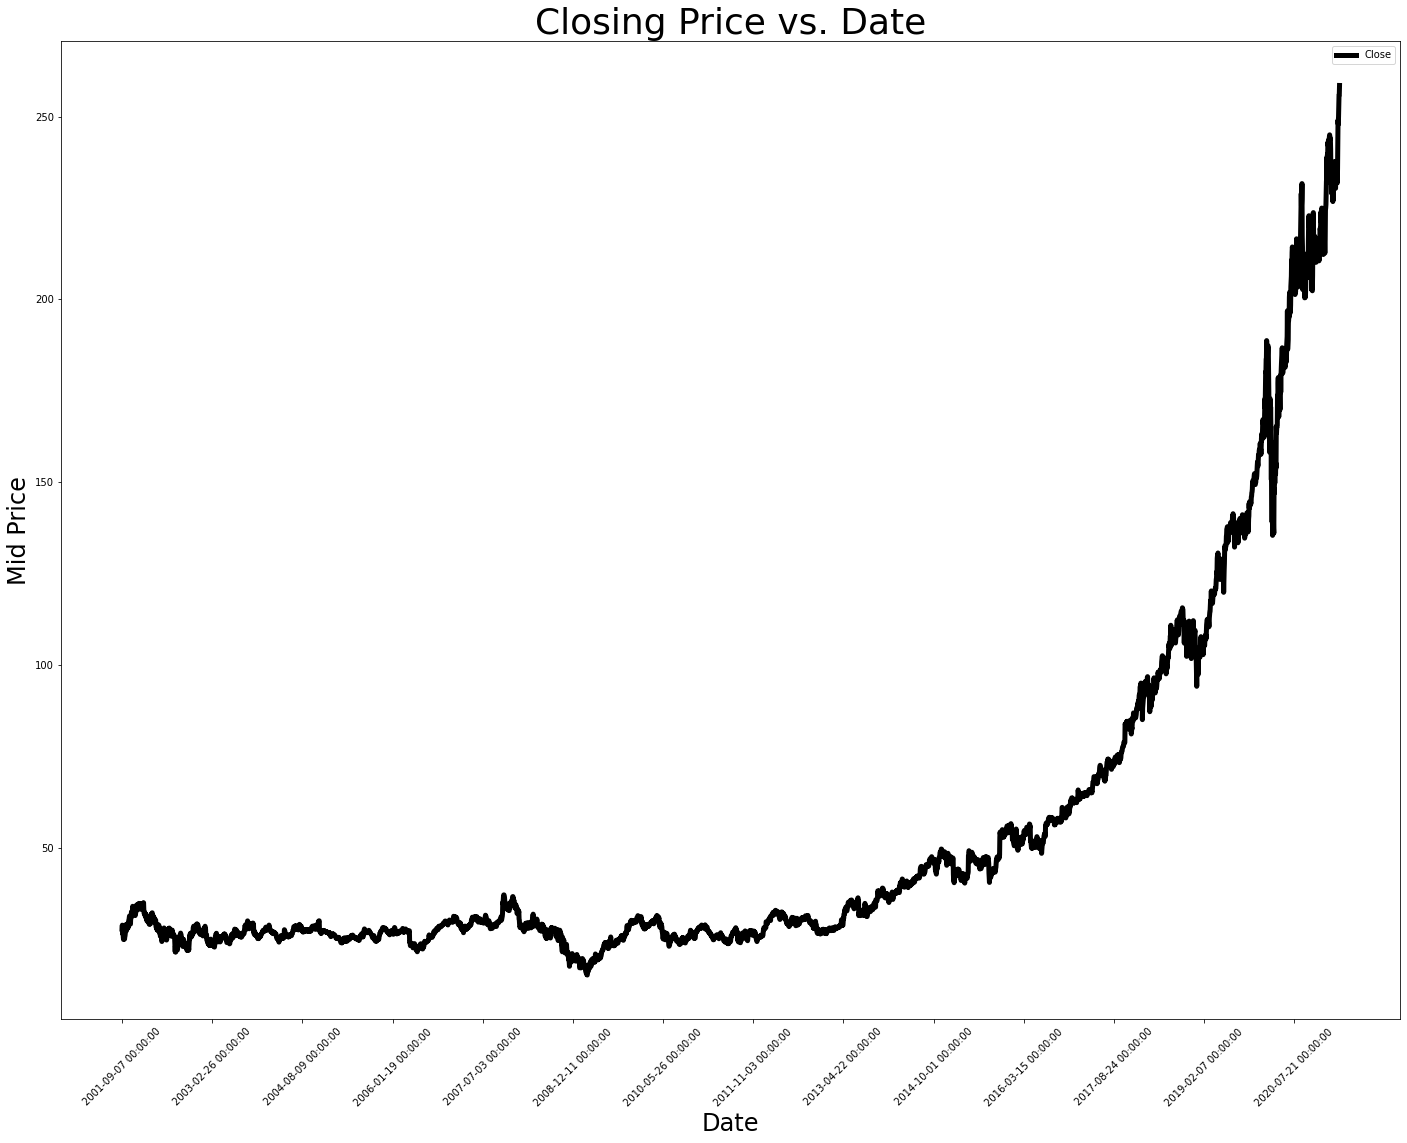

In [ ]:
fig = closing_data.get_line_plot( use_custom_df = True, df = closing_price_df, plot_features=False)
fig.show()

# Here's the next 5 day high/low prices overlaid over closing
Let's see the last 10% of data so we can see the different trends 

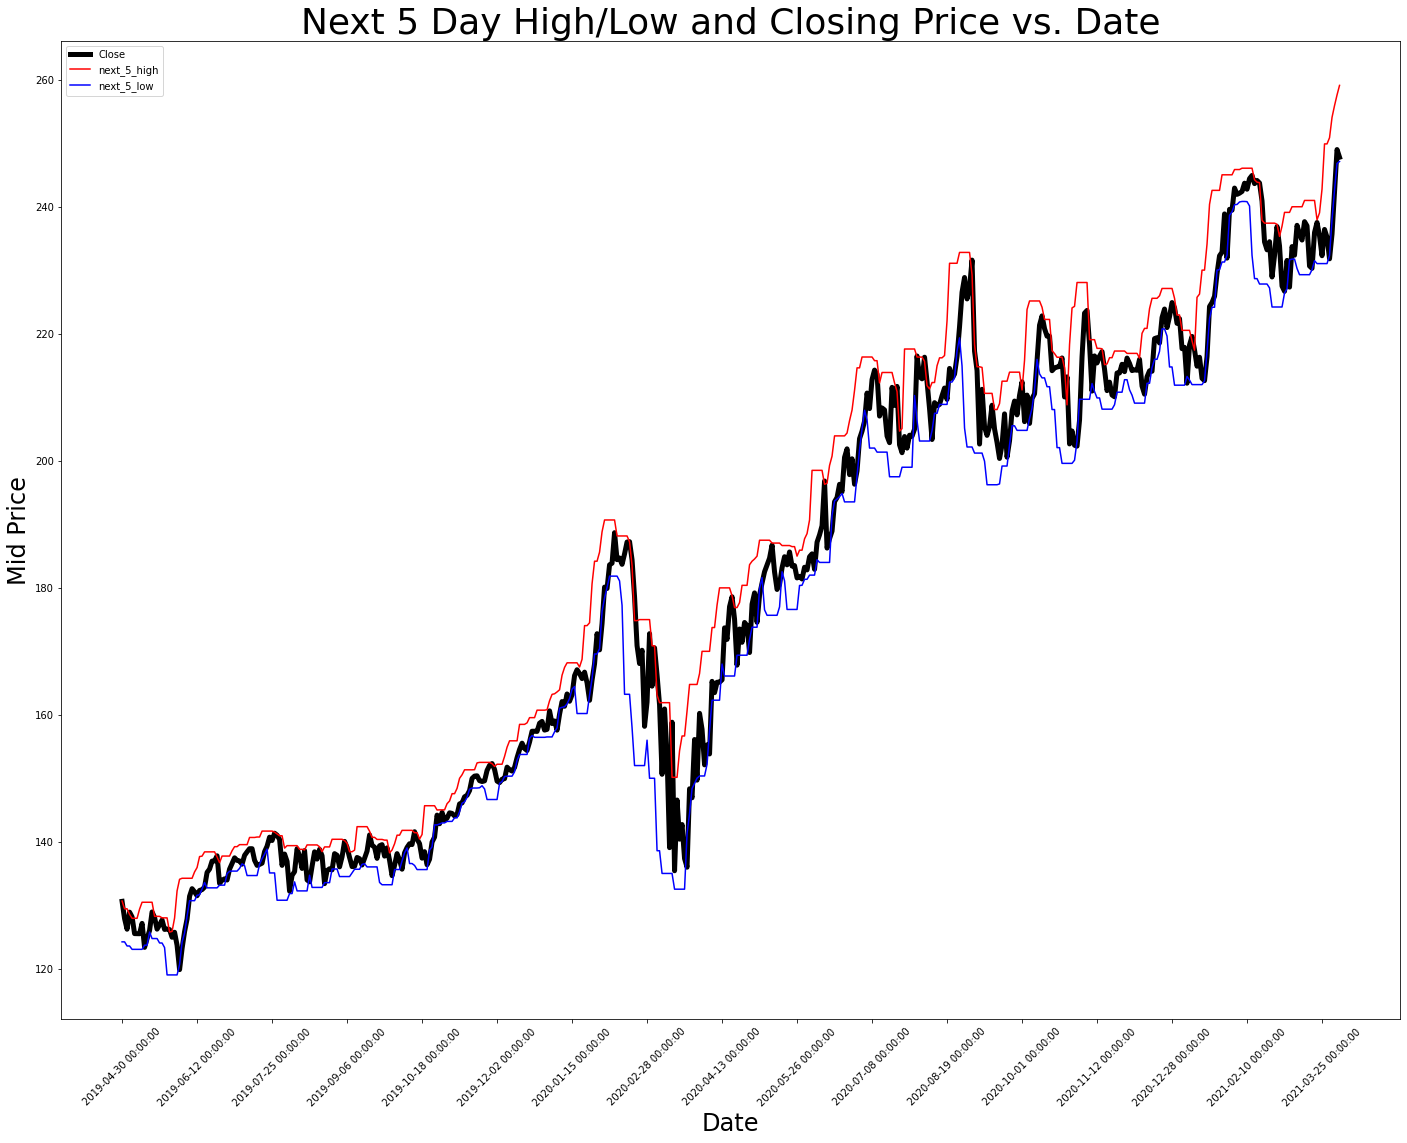

In [ ]:
dates = closing_price_df.index
start_date = dates[int(len(dates)*.9)]
end_date = dates[-1]
plot_df = five_day_high_df.join(five_day_low_df['next_5_low'])
fig = closing_data.get_next_high_low_plot(use_custom_df = True, df = plot_df.loc[start_date: end_date],  x_step=30)
fig.show()

# Technical Indicators 
Here we have plotted the 20, 50, and 100 weighted moving averages and volumed weighted average prices. Let's check out our indicators over the last 10 % of our data

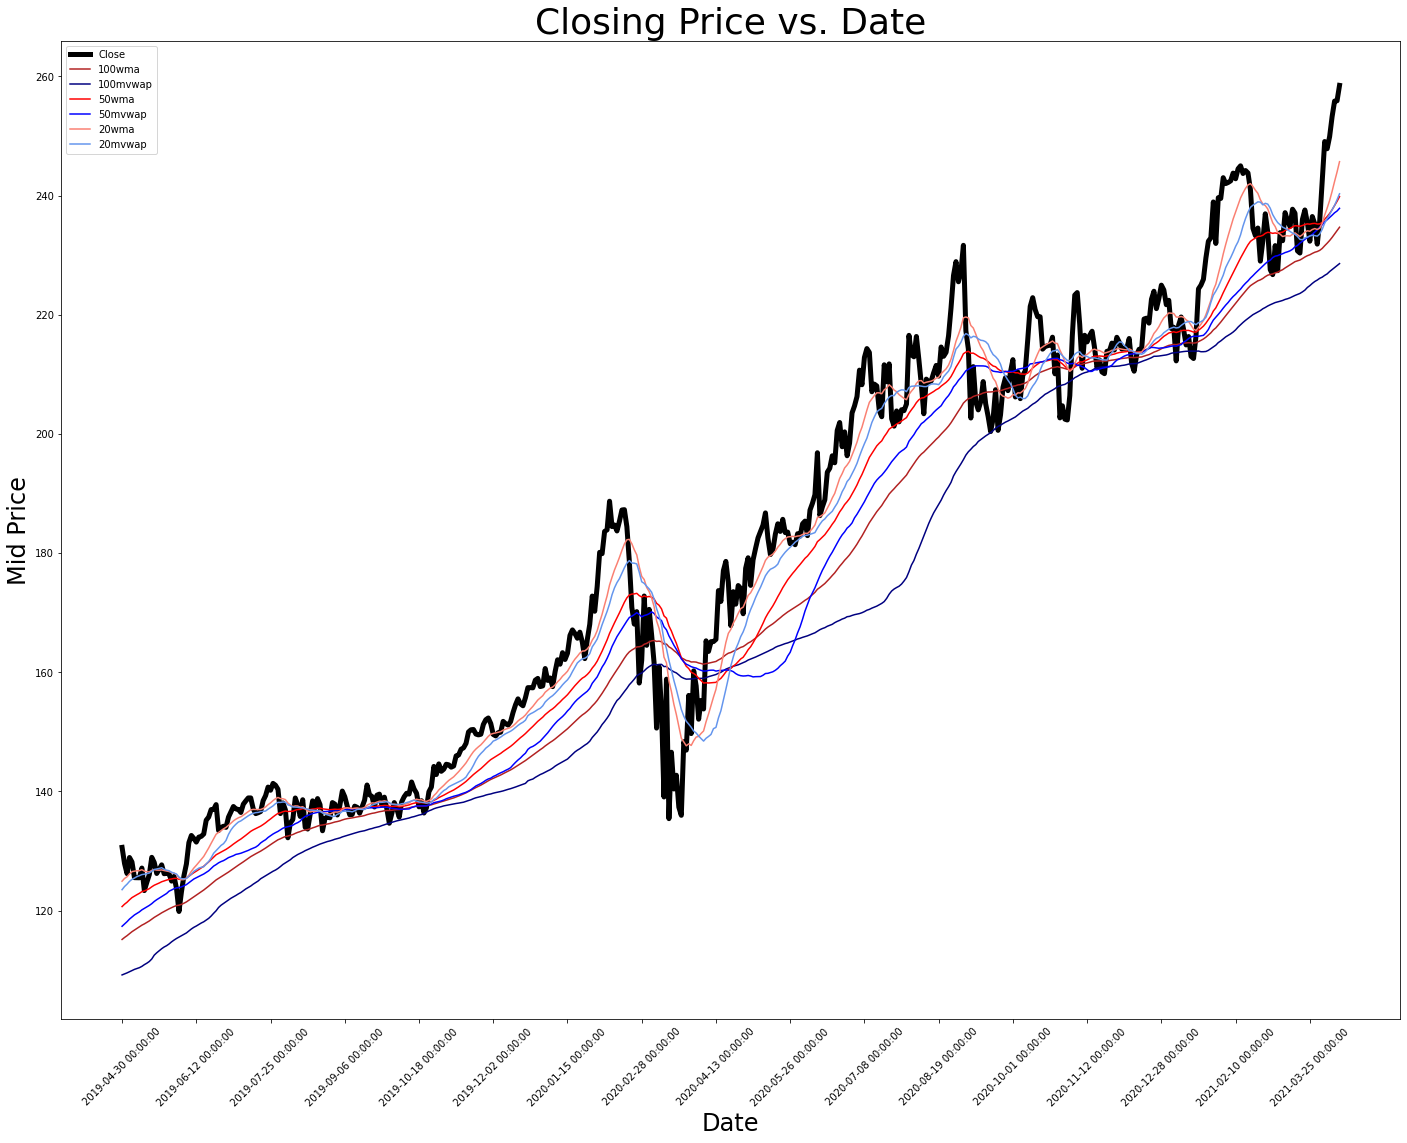

In [ ]:
fig = closing_data.get_line_plot( use_custom_df = True, df = closing_price_df.loc[start_date: end_date], plot_features=True, x_step=30)
fig.show()

# Define Model Names and Constants

In [ ]:
DIR_LOCATION = "./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/"
STOCK_NAME = STOCK_NAME
CLOSING_MODEL_NAME = f'{STOCK_NAME}_CLOSING_MODEL.h5'
FIVE_DAY_HIGH_MODEL_NAME = f'{STOCK_NAME}_FIVE_DAY_HIGH_MODEL.h5'
FIVE_DAY_LOW_MODEL_NAME = f'{STOCK_NAME}_FIVE_DAY_LOW_MODEL.h5'

# Define callbacks

In [ ]:
from google.colab import drive
import tensorflow as tf
drive.mount('/content/drive')

import datetime
import os


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)

closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + CLOSING_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

five_high_closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + FIVE_DAY_HIGH_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

five_low_closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + FIVE_DAY_LOW_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = DIR_LOCATION,
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_images=False, 
                                                      update_freq='epoch')

closing_callbacks = [early_stop, closing_monitor, lr_schedule]

five_high_callbacks = [early_stop, closing_monitor, lr_schedule]

five_low_callbacks = [early_stop, closing_monitor, lr_schedule]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Model Architectures

In [ ]:
import tensorflow as tf
## TODO: Make sure this is best performing model 
def model(batch_size = 1, ishape = (100,5), lr = 1e-2):
  model_input = tf.keras.layers.Input(shape = ishape, batch_size = 1)
  l3 = tf.keras.layers.LSTM(units = 20, return_sequences = True, return_state = True, stateful=True)(model_input)  #Use False for only 1 dim return, True = full sequence of hidden states
  l4 = tf.keras.layers.LSTM(units = 20, return_sequences = False)(l3)  #Use False for only 1 dim return, True = full sequence of hidden states
  output = tf.keras.layers.Dense(1, activation = 'linear')(l4)
  model = tf.keras.Model(inputs = model_input, outputs = output)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
                loss = tf.keras.losses.mean_squared_error) 
  return model


#ishape should be (timesteps, n_features)
BATCH_SIZE = 1
closing_model = model(batch_size = BATCH_SIZE, ishape=(100, closing_price_df.shape[1]))
# 15 features in these models (next high )
five_day_high_model = model(batch_size = BATCH_SIZE, ishape=(100, five_day_high_df.shape[1]))
five_day_low_model = model(batch_size = BATCH_SIZE, ishape=(100, five_day_low_df.shape[1]))


# Get custom time series data generators
Note: These generators were developed to provide windowed normalization. For the next 5 day high/low, the last 5 values are copied from the last valid data to avoid information from future steps being passed into training. (ie., 94th value is copied into 95-100th values for feautres generated with future data)

In [ ]:
# How about windowed normalization? We got you covered! Here we will use a min max scaler, but you can also use a standard scaler by passing min_max_scaler=False
train_scaled_closing_data, test_scaled_closing_data = StockData.get_timeseries_generators(df=closing_price_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='c',
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            target_idx = 3)


train_scaled_five_day_high, test_scaled_five_day_high = StockData.get_timeseries_generators(df=five_day_high_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='next_5_high',
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            mask = True, 
                                                                            mask_idx = 5, 
                                                                            target_idx = 3)

train_scaled_five_day_low, test_scaled_five_day_low = StockData.get_timeseries_generators(df=five_day_low_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='next_5_low',   
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            mask = True, 
                                                                            mask_idx = 5, 
                                                                            target_idx = 3 )

# Prepare Trainers



In [ ]:
# Arnold schwarzenegger likes to train
arnold_closing = Trainer(None, closing_model, CLOSING_MODEL_NAME, train_scaled_closing_data, test_scaled_closing_data)
arnold_next_high = Trainer(None, five_day_high_model, FIVE_DAY_HIGH_MODEL_NAME, train_scaled_five_day_high, test_scaled_five_day_high)
arnold_next_low = Trainer(None, five_day_low_model, FIVE_DAY_LOW_MODEL_NAME, train_scaled_five_day_low, test_scaled_five_day_low)

# Training Model - Tomorrow's Closing Price

In [ ]:
arnold_closing.train_model(1000, True, callbacks=closing_callbacks)

TRAINING
Epoch 1/1000

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3350/3350 [==============================] - 117s 34ms/step - loss: 0.1582

Epoch 00001: loss improved from inf to 0.14730, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/MSFT_CLOSING_MODEL.h5
Epoch 2/1000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3350/3350 [==============================] - 113s 34ms/step - loss: 0.1374

Epoch 00002: loss improved from 0.14730 to 0.11321, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/MSFT_CLOSING_MODEL.h5
Epoch 3/1000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3350/3350 [==============================] - 113s 34ms/step - loss: 0.0594

Epoch 00003: loss improved from 0.11321 to 0.05846, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/MSFT_CLOSING_MODEL.h5
Epoch 4/1000

Epoch 

In [ ]:
fig = arnold_closing.graph_loss()

# Training Model - Next 5 Day High Price

In [ ]:
arnold_next_high.train_model(1000, True, callbacks=five_high_callbacks)

In [ ]:
fig = arnold_next_high.graph_loss()

# Training Model - Next 5 Day Low Price

In [ ]:
arnold_next_low.train_model(1000, True, callbacks=five_low_callbacks)

In [ ]:
fig = arnold_next_low.graph_loss()

# Results - Tomorrow's Closing Price

In [ ]:
from deeptendies.result_plots import ModelResultPlots

closing_model.load_weights(DIR_LOCATION + CLOSING_MODEL_NAME)
arnold_closing.model = closing_model
def get_results(df, train_data_gen, model, title = "Closing Price vs. Date", predicted_value_name = "stock price"): 
  train_idx, test_idx= StockData.get_train_test_split(df)
  days = [str(x).split("T")[0] for x in df.index[train_idx+train_data_gen.length:].values]
  predictions = model.get_predictions()
  y_true = predictions['actual']
  y_predicted = predictions['predicted']
  fig = ModelResultPlots.plot_predicted_vs_original_price(y_true, y_predicted, STOCK_NAME, days, x_step=91)
  return fig, y_true, y_predicted


fig, y_true, y_predicted = get_results(closing_price_df, train_scaled_closing_data, arnold_closing)
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{CLOSING_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

# Results - Next 5 Day High Price

In [ ]:
fig, y_true, y_predicted = get_results(five_day_high_df, train_scaled_five_day_high, arnold_next_high, title = "Next Five Day High Price vs. Date", predicted_value_name = "5 day high price")
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{FIVE_DAY_HIGH_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

# Results - Next 5 Day Low Price

In [ ]:
fig, y_true, y_predicted = get_results(five_day_low_df, train_scaled_five_day_low, arnold_next_low, title = "Next Five Day Low Price vs. Date", predicted_value_name = "5 day low price")
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{FIVE_DAY_LOW_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()